In [2]:
%pylab inline
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spec_utils import read_irs

from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir.slabspec import make_spec

from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples

Populating the interactive namespace from numpy and matplotlib


In [4]:
#loading in data
info1=pd.read_csv('Characteristics Sheet.csv')
info1=pd.DataFrame(info1)

info2=pd.read_csv('Molecular Catalog.csv',skipfooter=8)
info2=pd.DataFrame(info2)

#merge two dataframes into one
info_master=pd.merge(info1,info2,on='Star',how='outer')

/Users/dougcobb/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [5]:
#water
masterv2=info_master[info_master != -99]
water=masterv2.dropna(subset=['H2O_15.17_microns','H2O_17.22_microns','H2O_29.85_microns'])
#OH
oh=masterv2.dropna(subset=['OH_23.2_microns','OH_27.6_microns'])
#HCN
hcn=masterv2.dropna(subset=['HCN_flux'])
#C2H2
c2h2=masterv2.dropna(subset=['C2H2_flux'])
#CO2
co2=masterv2.dropna(subset=['CO2_flux'])
#NeII
neii=masterv2.dropna(subset=['NeII_12.8_flux'])

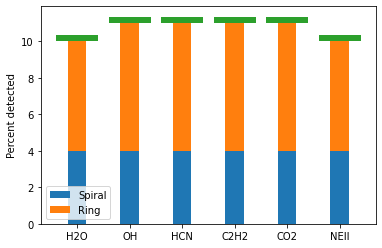

In [12]:
#stacked bar chart
spiral = np.array((len(water[water['Disk_has_spirals'] == 'TRUE']), len(oh[oh['Disk_has_spirals'] == 'TRUE']),
len(hcn[hcn['Disk_has_spirals'] == 'TRUE']), len(c2h2[c2h2['Disk_has_spirals'] == 'TRUE']),
len(co2[co2['Disk_has_spirals'] == 'TRUE']), len(neii[neii['Disk_has_spirals'] == 'TRUE'])))
ring = np.array((len(water[water['Disk_has_Rings'] == 'TRUE']), len(oh[oh['Disk_has_Rings'] == 'TRUE']),
len(hcn[hcn['Disk_has_Rings'] == 'TRUE']), len(c2h2[c2h2['Disk_has_Rings'] == 'TRUE']),
len(co2[co2['Disk_has_Rings'] == 'TRUE']), len(neii[neii['Disk_has_Rings'] == 'TRUE'])))

ind = np.arange(6) #change from 5 to 6 to reflect six molecules
width = 0.35 #leave width for now
p1 = plt.bar(ind, spiral, width)
p2 = plt.bar(ind, ring, width,  bottom=spiral)
p3 = plt.bar(ind, width,  bottom=spiral+ring)
plt.ylabel('Percent detected')
plt.xticks(ind, ('H2O', 'OH', 'HCN', 'C2H2', 'CO2', 'NEII')) #replace tick marks to reflect six molecules
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Spiral', 'Ring'))
plt.show()

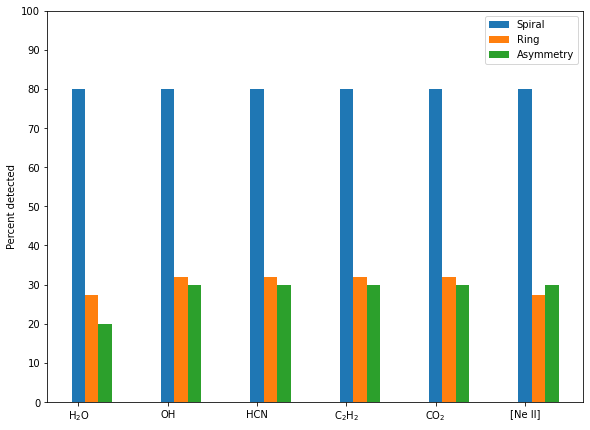

In [13]:
#Anna's code

#stacked bar chart
#import statement
from matplotlib import ticker
#create blank figure
plt.figure(figsize=(9.6,7.2))
#spiral data
spiral1= len(water[water['Disk_has_spirals'] == 'TRUE']) / (len(info_master[info_master['Disk_has_spirals'] == 'TRUE']))
spiral2= len(oh[oh['Disk_has_spirals'] == 'TRUE']) / (len(info_master[info_master['Disk_has_spirals'] == 'TRUE']))
spiral3= len(hcn[hcn['Disk_has_spirals'] == 'TRUE']) / (len(info_master[info_master['Disk_has_spirals'] == 'TRUE']))
spiral4= len(c2h2[c2h2['Disk_has_spirals'] == 'TRUE']) / (len(info_master[info_master['Disk_has_spirals'] == 'TRUE']))
spiral5= len(co2[co2['Disk_has_spirals'] == 'TRUE']) / (len(info_master[info_master['Disk_has_spirals'] == 'TRUE']))
spiral6= len(neii[neii['Disk_has_spirals'] == 'TRUE']) / (len(info_master[info_master['Disk_has_spirals'] == 'TRUE']))
spiral = 100*np.array((spiral1,spiral2,spiral3,spiral4,spiral5,spiral6))
#ring data
ring1= len(water[water['Disk_has_Rings'] == 'TRUE']) / (len(info_master[info_master['Disk_has_Rings'] == 'TRUE']))
ring2= len(oh[oh['Disk_has_Rings'] == 'TRUE']) / (len(info_master[info_master['Disk_has_Rings'] == 'TRUE']))
ring3= len(hcn[hcn['Disk_has_Rings'] == 'TRUE']) / (len(info_master[info_master['Disk_has_Rings'] == 'TRUE']))
ring4= len(c2h2[c2h2['Disk_has_Rings'] == 'TRUE']) / (len(info_master[info_master['Disk_has_Rings'] == 'TRUE']))
ring5= len(co2[co2['Disk_has_Rings'] == 'TRUE']) / (len(info_master[info_master['Disk_has_Rings'] == 'TRUE']))
ring6= len(neii[neii['Disk_has_Rings'] == 'TRUE']) / (len(info_master[info_master['Disk_has_Rings'] == 'TRUE']))
ring = 100*np.array((ring1,ring2,ring3,ring4,ring5,ring6))
        
#annular substructure data
asym1= len(water[water['Disk_Asymmetry'] == 'TRUE']) / (len(info_master[info_master['Disk_Asymmetry'] == 'TRUE']))
asym2= len(oh[oh['Disk_Asymmetry'] == 'TRUE']) / (len(info_master[info_master['Disk_Asymmetry'] == 'TRUE']))
asym3= len(hcn[hcn['Disk_Asymmetry'] == 'TRUE']) / (len(info_master[info_master['Disk_Asymmetry'] == 'TRUE']))
asym4= len(c2h2[c2h2['Disk_Asymmetry'] == 'TRUE']) / (len(info_master[info_master['Disk_Asymmetry'] == 'TRUE']))
asym5= len(co2[co2['Disk_Asymmetry'] == 'TRUE']) / (len(info_master[info_master['Disk_Asymmetry'] == 'TRUE']))
asym6= len(neii[neii['Disk_Asymmetry'] == 'TRUE']) / (len(info_master[info_master['Disk_Asymmetry'] == 'TRUE']))
asym = 100*np.array((asym1,asym2,asym3,asym4,asym5,asym6))
       
ind = np.arange(6)
width = 0.15 #leave width for now      
p1 = plt.bar(ind, spiral, width) 
p2 = plt.bar(ind+width, ring, width)
p3 = plt.bar(ind+width*2, asym, width)
plt.ylabel('Percent detected')
plt.xticks(ind, (r'H$_2$O', 'OH', 'HCN', r'C$_2$H$_2$', r'CO$_2$', '[Ne II]')) #replace tick marks to reflect six molecules
plt.yticks(np.arange(0, 110, 10))
plt.legend((p1[0], p2[0], p3[0]), ('Spiral', 'Ring', 'Asymmetry'))
plt.show()